In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from nltk.lm import Vocabulary
from tqdm import tqdm
from functools import reduce
from math import ceil

In [2]:
opus = pd.read_pickle("../data/raw/opus_sentences.pkl")
print(opus.shape)
opus.head()

(108017, 3)


,file,order,text
0,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,0,Source: librosgratis.liblit.com/
1,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,1,LAS AVENTURAS DE SHERLOCK HOLMES
2,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,2,Arthur Conan Doyle
3,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,3,1.
4,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,4,Escándalo en Bohemia


In [3]:
vocabulary = set("".join(opus["text"].to_list()))

In [4]:
char_to_ix = {k:i for i, k in enumerate(vocabulary, 3)}
char_to_ix["<pad>"] = 0
char_to_ix["<bos>"] = 1
char_to_ix["<eos>"] = 2
len(char_to_ix)

136

In [5]:
ix_to_char = {char_to_ix[k]:k for k in char_to_ix.keys()}

# generate training data

In [6]:
def text_to_ix(text):
    return [1] + [char_to_ix[c] for c in text] + [2]

In [7]:
def ix_to_text(ixs):
    return "".join([ix_to_char[i] for i in ixs])

In [8]:
def pad(x, l):
    if len(x) < l:
        #print(x)
        return x + [0 for i in range(l - len(x))]
    else:
        return x[:l-1] + [2]
    
len(pad(list(range(25)), 25))

25

In [9]:
letters = list(sorted(vocabulary))

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                #print(char_to_ix[random_letter])
                noisy_sentence.append(random_letter)
                #noisy_sentence.append(char_to_ix[random_letter])
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass     
        i += 1
    #return noisy_sentence
    return "".join(noisy_sentence)

noise_maker("Relocate, remove, or add characters to create spelling mistakes", 0.97)

'Relocate, remove, or add cahacters to create spelling mistakes'

In [10]:
from timeit import default_timer

In [11]:
opus["text"].map(len).describe(percentiles = np.arange(0, 1, 0.1))

count    108017.000000
mean        108.709648
std          98.915442
min           1.000000
0%            1.000000
10%          22.000000
20%          35.000000
30%          49.000000
40%          65.000000
50%          83.000000
60%         103.000000
70%         129.000000
80%         163.000000
90%         222.000000
max        2249.000000
Name: text, dtype: float64

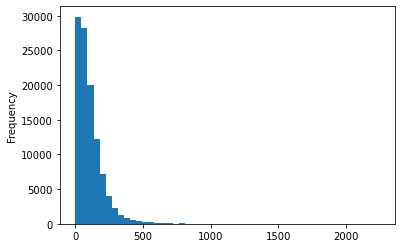

In [12]:
opus["text"].map(len).plot.hist(bins = 50)

In [24]:
noise_examples = 5
threshold = 0.95
sample_size = 10

start = default_timer()

preprocess = pd.DataFrame(opus["text"].sample(n = sample_size))\
.assign(noisy_sentences = lambda df: df["text"].map(lambda x:  [x] * 5 \
                                                    + [noise_maker(x, threshold) 
                                                       for i in range(noise_examples)]))\
.explode("noisy_sentences")\
.assign(X = lambda df: df["noisy_sentences"]\
        .map(text_to_ix),
        Y = lambda df: df["text"]\
        .map(text_to_ix))\
.reset_index(drop = True)

print(default_timer() - start)

print(preprocess.shape)
preprocess.head(50)

0.107854800000041
(100, 4)


,text,noisy_sentences,X,Y
0,––Se ha intentado cinco veces.,––Se ha intentado cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
1,––Se ha intentado cinco veces.,––Se ha intentado cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
2,––Se ha intentado cinco veces.,––Se ha intentado cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
3,––Se ha intentado cinco veces.,––Se ha intentado cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
4,––Se ha intentado cinco veces.,––Se ha intentado cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
5,––Se ha intentado cinco veces.,––oSe ha intentad ocinco veces.,"[1, 116, 116, 104, 22, 23, 123, 98, 27, 123, 7...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
6,––Se ha intentado cinco veces.,––Se ha inentado cinoc veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
7,––Se ha intentado cinco veces.,––Se ha intentado cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
8,––Se ha intentado cinco veces.,––Se ha intentado cinco vece.s,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."
9,––Se ha intentado cinco veces.,––Se ha intentaod cinco veces.,"[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,...","[1, 116, 116, 22, 23, 123, 98, 27, 123, 76, 7,..."


In [25]:
preprocess["X"].map(len).describe()

count    100.000000
mean     119.280000
std       87.482764
min       18.000000
25%       46.000000
50%      105.000000
75%      163.000000
max      322.000000
Name: X, dtype: float64

In [26]:
preprocess["Y"].map(len).describe()

count    100.000000
mean     119.300000
std       87.711706
min       18.000000
25%       46.000000
50%      104.500000
75%      163.000000
max      322.000000
Name: Y, dtype: float64

In [27]:
# X = torch.stack(preprocess["X"].map(torch.tensor).to_list())
# X.shape

In [28]:
# Y = torch.stack(preprocess["Y"].map(torch.tensor).to_list())
# Y.shape

# model

100%|██████████| 20/20 [00:37<00:00,  1.89s/it]

final loss: 2.73144268989563


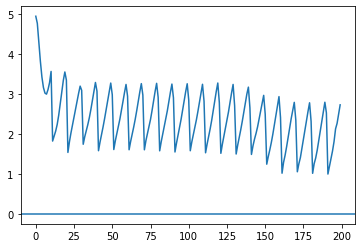

––Se ha intentado cinco veces.
<bos>ùäùyyyòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòòò


'<bos>Pe                                                                                                                                                                                                                                                                                                                                                                                                              '

In [37]:
class CharLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocabulary_size, layers):
        super(CharLSTM, self).__init__()
        self.embeddings = nn.Embedding(vocabulary_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, layers)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, layers)
        self.decoder_to_vocabulary = nn.Linear(hidden_dim, vocabulary_size)
        self.vocabulary_size = vocabulary_size
    
    def forward(self, sentence, current_token):
        embeddings = self.embeddings(sentence).transpose(0, 1)
        sequence, hidden = self.encoder(embeddings)
        current_token_embeddings = self.embeddings(current_token).transpose(0, 1)
        chars, final_hidden = self.decoder(current_token_embeddings, hidden)
        chars = self.decoder_to_vocabulary(chars).transpose(0, 1)
        return chars.log_softmax(-1), final_hidden
    
    def fit(self, X, Y, lr = 0.1, epochs = 20, batch_size = 10):
        X, Y = X.to_list(), Y.to_list()
        loss_function = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr)
        losses = []
        # generate batches
        X_batch = []
        Y_batch = []
        for i in range(ceil(len(X) / batch_size)):
            x, y = X[i:i + batch_size], Y[i:i + batch_size]
            x_max_length, y_max_length = max([len(s) for s in x]), max([len(s) for s in y])
            x, y = [pad(s, x_max_length) for s in x], [pad(s, y_max_length) for s in y]
            x, y = torch.tensor(x), torch.tensor(y)
#             print(x.shape)
#             print(y.shape)
            X_batch.append(x)
            Y_batch.append(y)
        # do the training
        for i in tqdm(range(epochs)):
            for x, y in zip(X_batch, Y_batch):
                outputs, last_hidden = self(x, y[:, :-1])
                outputs = outputs.transpose(1, 2).squeeze()
                loss = loss_function(outputs, y[:, 1:])
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                losses.append(loss.item())
        print("final loss:", losses[-1])
        plt.axhline(0)
        plt.plot(losses)
        plt.show()
        
    def spellcheck(self, sentence, max_length = 400):
        sentence = sentence.replace("<bos>", "").replace("<eos>", "").replace("<pad>", "")
        sentence = torch.tensor(text_to_ix(sentence))
        sentence_embeddings = self.embeddings(sentence).unsqueeze(1)
        sequence, hidden = self.encoder(sentence_embeddings)
        output = [1]
        for i in range(max_length):
            current_token = self.embeddings(torch.tensor([output[-1]])).unsqueeze(1)
            next_token, hidden = self.decoder(current_token, hidden)
            next_token = self.decoder_to_vocabulary(next_token).argmax(-1).item()
            output.append(next_token)
            if next_token == 2 or next_token == 0:
                break
        return ix_to_text(output)

    
n = 4
net = CharLSTM(n, n, len(char_to_ix), 2)

test_string = preprocess["text"][0]
before_training = net.spellcheck(test_string)

net.fit(preprocess["X"], preprocess["Y"])

print(test_string)
print(before_training)
net.spellcheck(test_string)

In [38]:
net.spellcheck("<bos>A falta de lajfkdjfs maravilfdsafsdfasl<eos>")

'<bos>P<pad>'